In [ ]:
# Install PySpark and other dependencies in Colab
!pip install pyspark findspark numpy pandas matplotlib seaborn scipy imblearn tensorflow scikit-learn
# Import necessary libraries
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, mean, stddev, count, when, isnan
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.stat import Correlation
import numpy as np
from scipy.stats import pointbiserialr, f_oneway
from imblearn.combine import SMOTEENN
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Smart Grid Stability Analysis") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.ui.port", "4050") \
    .master("local[*]") \
    .getOrCreate()
# Load dataset directly from the given path
file_path = "/content/smart_grid_stability_augmented.csv"
print(f"Loading dataset from {file_path}")
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Display basic information
print("\nDataset Schema:")
df.printSchema()
print("\nDataset Overview:")
df.describe().show()
print("\nSample Data:")
df.show(5)

Loading dataset from /content/smart_grid_stability_augmented.csv

Dataset Schema:
root
 |-- tau1: double (nullable = true)
 |-- tau2: double (nullable = true)
 |-- tau3: double (nullable = true)
 |-- tau4: double (nullable = true)
 |-- p1: double (nullable = true)
 |-- p2: double (nullable = true)
 |-- p3: double (nullable = true)
 |-- p4: double (nullable = true)
 |-- g1: double (nullable = true)
 |-- g2: double (nullable = true)
 |-- g3: double (nullable = true)
 |-- g4: double (nullable = true)
 |-- stab: double (nullable = true)
 |-- stabf: string (nullable = true)


Dataset Overview:
+-------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+--------+
|summary|              tau1|             tau2|             tau3|             tau4|                p1|                 p2|              

In [ ]:
# Check for missing values
def count_nulls(df):
    print("\nNull Values Count:")
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

count_nulls(df)

# Data Preprocessing
pdf = df.toPandas()
target_col = 'stabf'
if target_col not in pdf.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataset.")

print(f"\nTarget column: {target_col}")
unique_target_values = pdf[target_col].unique()
print(f"Unique values in target column: {unique_target_values}")
print("\nData types of columns:")
print(pdf.dtypes)

if pdf[target_col].dtype == 'object':
    print(f"\nConverting categorical target '{target_col}' to numeric")
    target_mapping = {val: i for i, val in enumerate(pdf[target_col].unique())}
    pdf[f"{target_col}_numeric"] = pdf[target_col].map(target_mapping)
    print("Target mapping:", target_mapping)
else:
    pdf[f"{target_col}_numeric"] = pdf[target_col]

plt.style.use('fivethirtyeight')
sns.set_palette("viridis")

print("\nColumn Names:")
for i, col_name in enumerate(df.columns):
    print(f"{i}: {col_name}")



Null Values Count:
+----+----+----+----+---+---+---+---+---+---+---+---+----+-----+
|tau1|tau2|tau3|tau4| p1| p2| p3| p4| g1| g2| g3| g4|stab|stabf|
+----+----+----+----+---+---+---+---+---+---+---+---+----+-----+
|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|  0|  0|   0|    0|
+----+----+----+----+---+---+---+---+---+---+---+---+----+-----+


Target column: stabf
Unique values in target column: ['unstable' 'stable']

Data types of columns:
tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

Converting categorical target 'stabf' to numeric
Target mapping: {'unstable': 0, 'stable': 1}

Column Names:
0: tau1
1: tau2
2: tau3
3: tau4
4: p1
5: p2
6: p3
7: p4
8: g1
9: g2
10: g3
11: g4
12: stab
13: stabf



Plotting feature distributions...


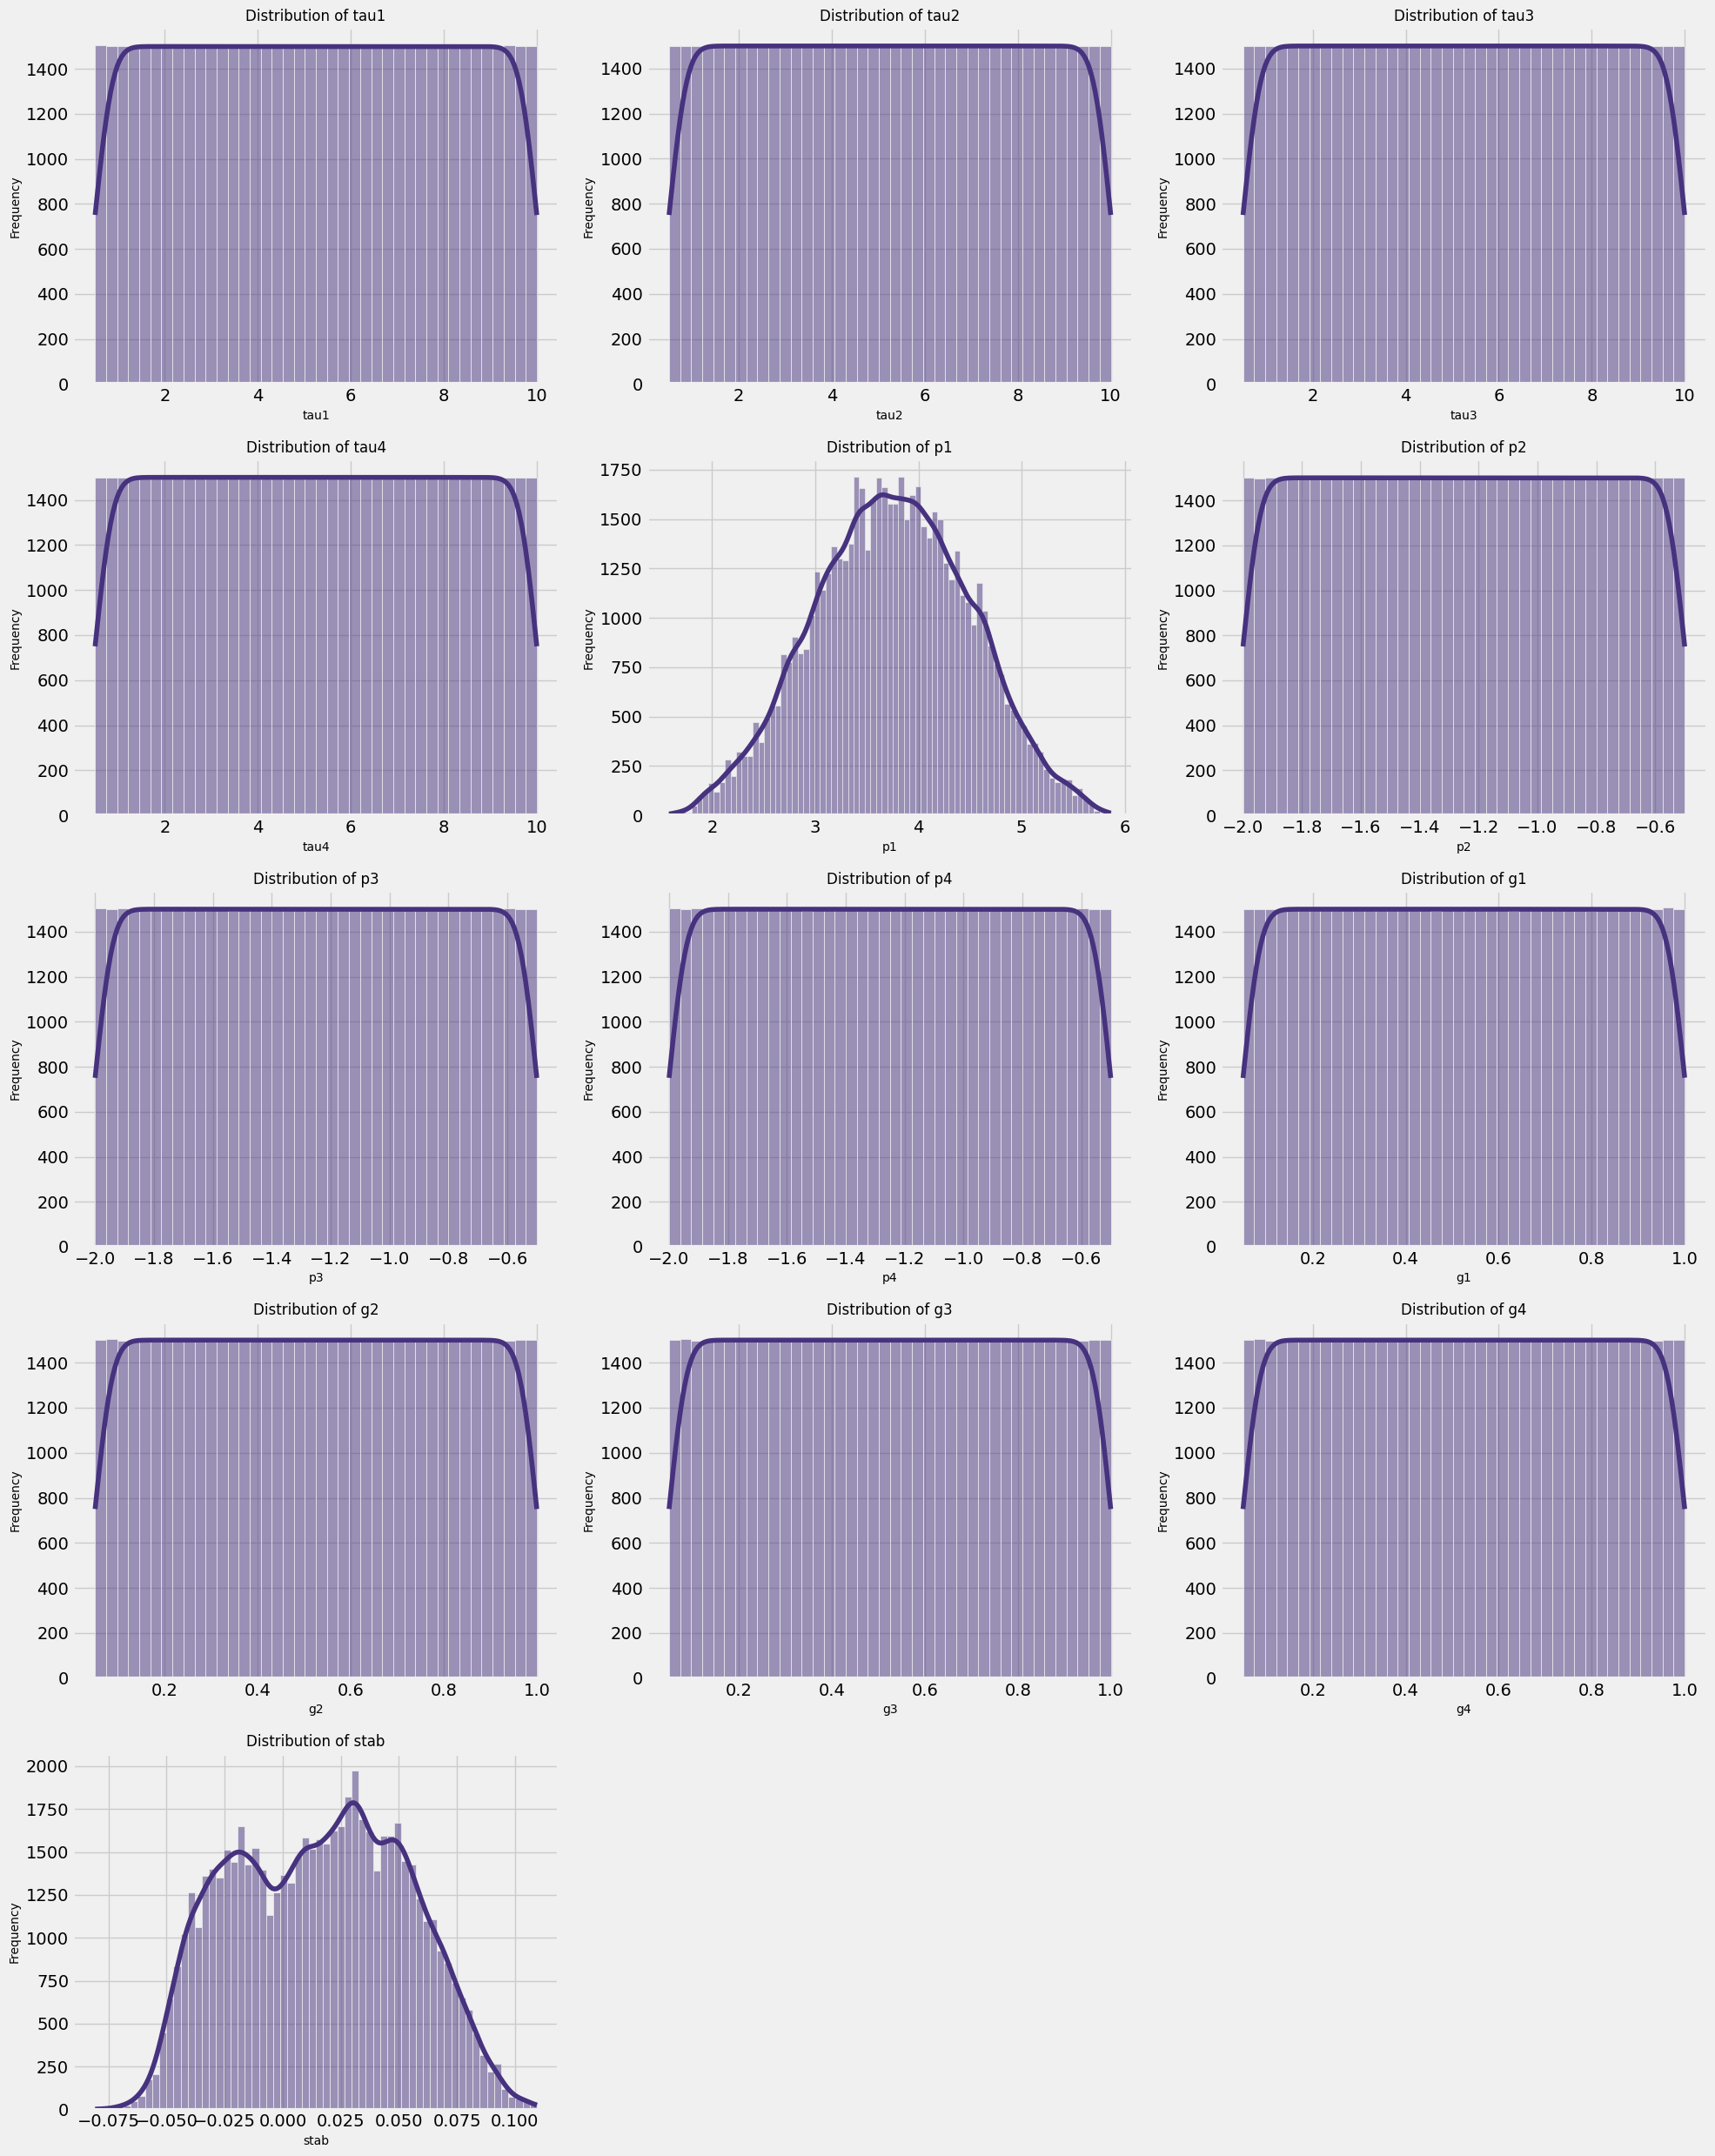


Plotting correlation with target (binary)...


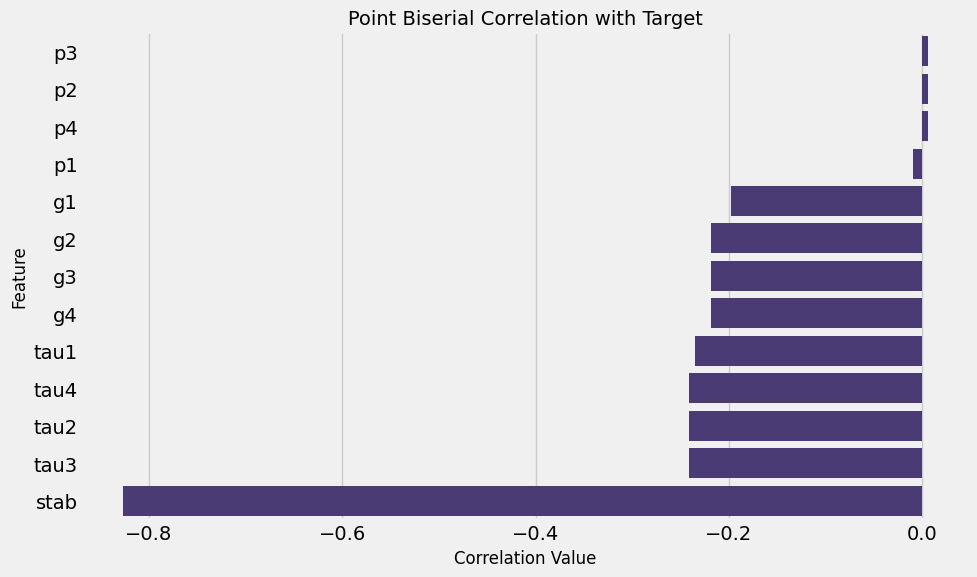

In [ ]:
# Visualize data distribution
def plot_feature_distributions(pdf):
    features = pdf.columns[:-2]
    n_features = len(features)
    n_rows = (n_features + 2) // 3
    plt.figure(figsize=(20, n_rows * 5))
    for i, feature in enumerate(features):
        plt.subplot(n_rows, 3, i + 1)
        if pdf[feature].dtype == 'object':
            sns.countplot(y=pdf[feature])
            plt.title(f'Distribution of {feature} (Categorical)', fontsize=12)
        else:
            sns.histplot(pdf[feature], kde=True)
            plt.title(f'Distribution of {feature}', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
    plt.tight_layout()
    plt.show()

print("\nPlotting feature distributions...")
plot_feature_distributions(pdf)

# Correlation Analysis
def plot_target_correlation(pdf, target_col, target_type):
    numeric_cols = pdf.select_dtypes(include=['number']).columns.tolist()
    if f"{target_col}_numeric" in numeric_cols:
        numeric_cols.remove(f"{target_col}_numeric")
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    if len(numeric_cols) == 0:
        print("No numeric features found for correlation analysis")
        return
    if target_type == 'binary':
        correlations = {col: pointbiserialr(pdf[f"{target_col}_numeric"], pdf[col])[0] for col in numeric_cols}
        corr_df = pd.Series(correlations).sort_values(ascending=False)
        title = "Point Biserial Correlation with Target"
    elif target_type == 'multi-class':
        correlations = {col: f_oneway(*[pdf[col][pdf[f"{target_col}_numeric"] == cls] for cls in pdf[f"{target_col}_numeric"].unique()])[0] for col in numeric_cols}
        corr_df = pd.Series(correlations).sort_values(ascending=False)
        title = "ANOVA F-Statistic with Target"
    else:
        correlations = pdf[numeric_cols].corrwith(pdf[f"{target_col}_numeric"]).abs().sort_values(ascending=False)
        corr_df = correlations
        title = "Pearson Correlation with Target"
    plt.figure(figsize=(10, 6))
    sns.barplot(x=corr_df.values, y=corr_df.index)
    plt.title(title, fontsize=14)
    plt.xlabel("Correlation Value", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

if pdf[target_col].dtype == 'object':
    num_classes = len(unique_target_values)
    target_type = 'binary' if num_classes == 2 else 'multi-class'
else:
    target_type = 'numeric'
print(f"\nPlotting correlation with target ({target_type})...")
plot_target_correlation(pdf, target_col, target_type)



Plotting boxplots to identify outliers...


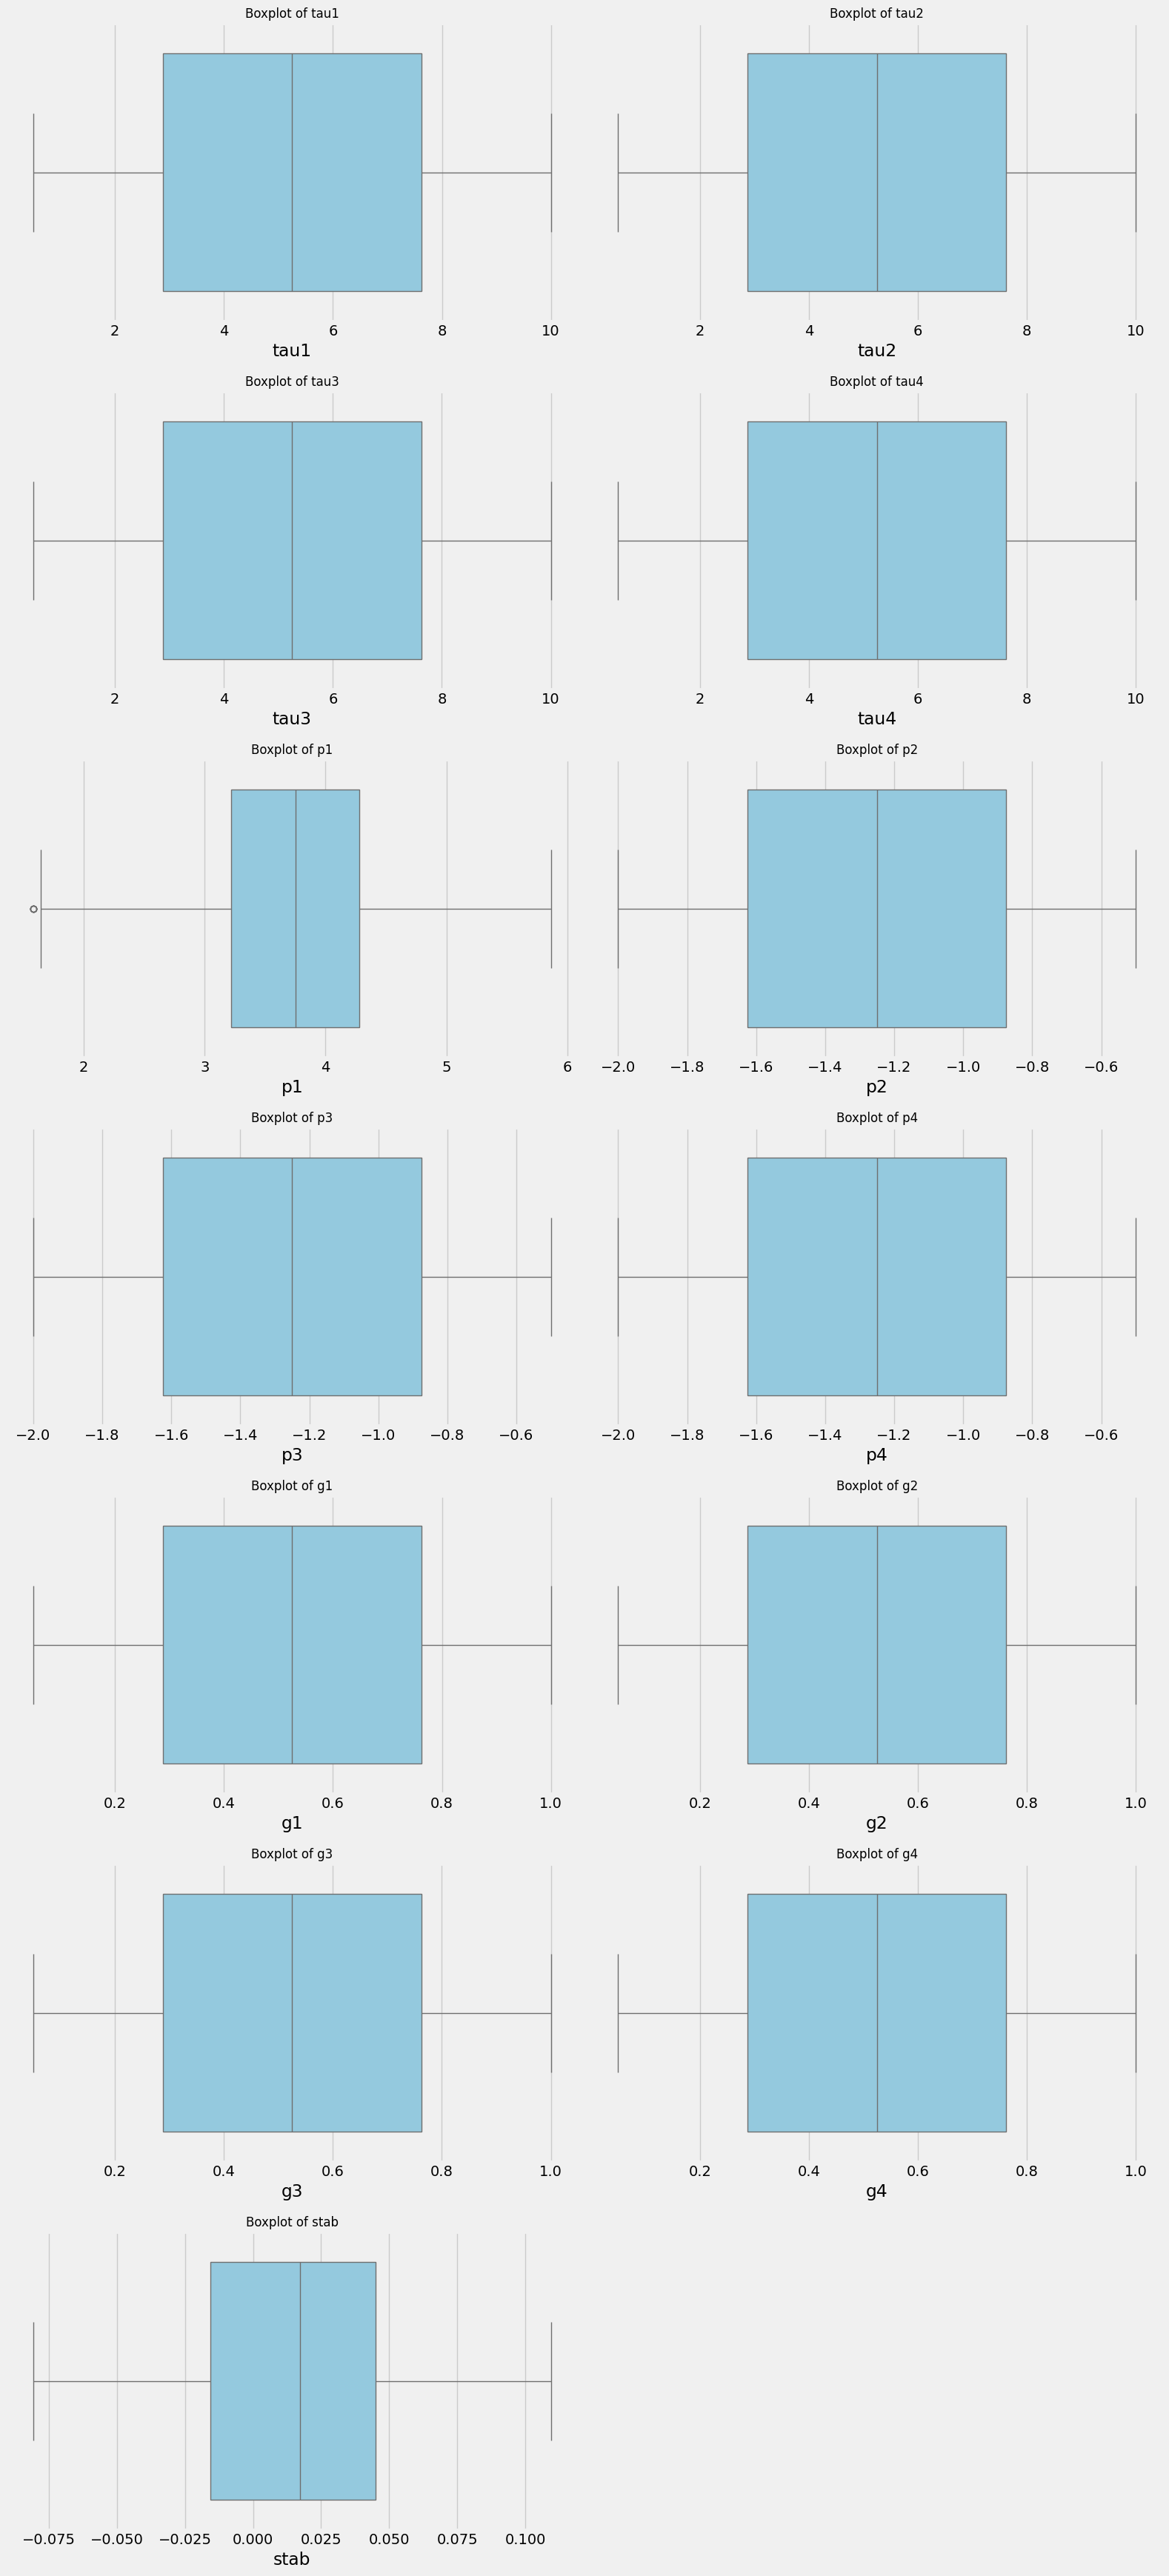


Plotting target distribution...


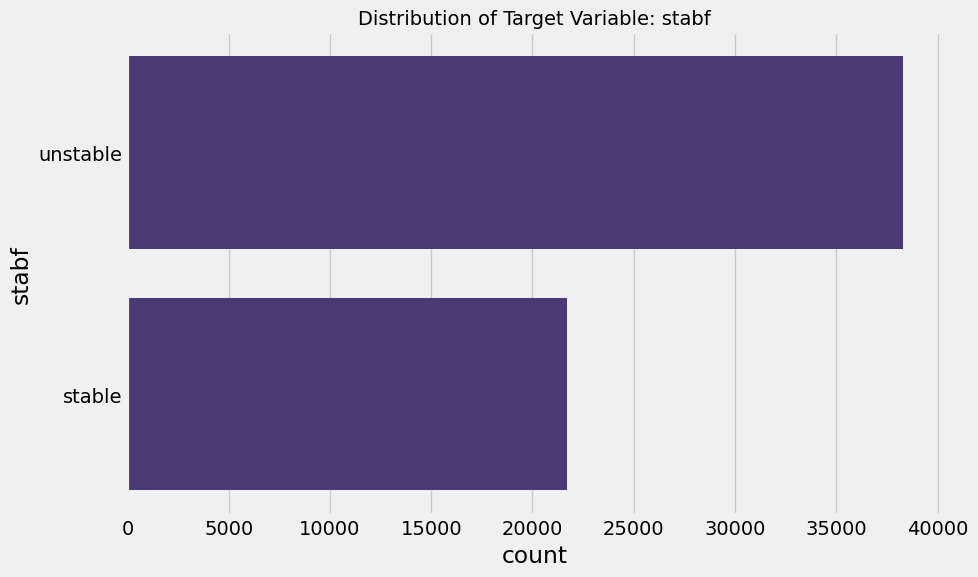


Creating pair plot of selected features...

Creating pair plot with top 5 features
Selected features: ['stab', 'tau4', 'tau2', 'tau3', 'tau1']


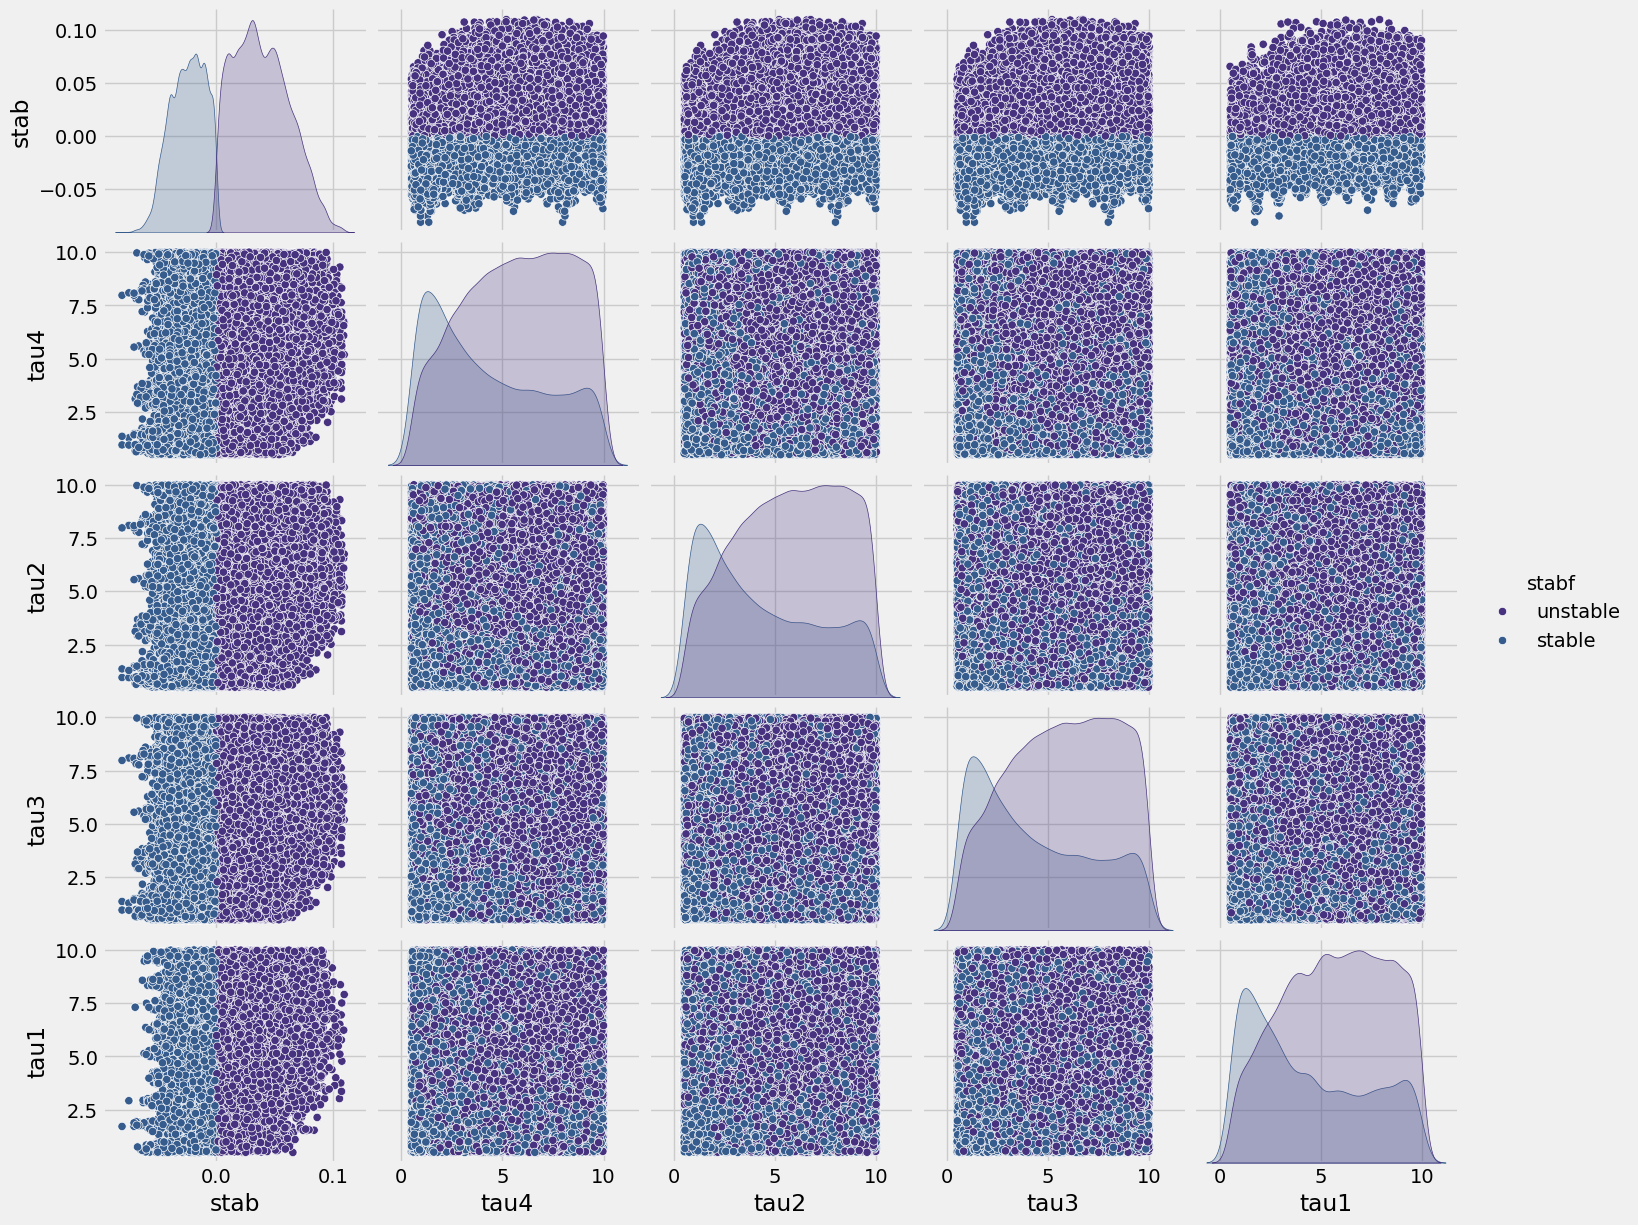

In [ ]:
# Boxplots
def plot_boxplots(pdf):
    numeric_features = pdf.select_dtypes(include=['number']).columns.tolist()
    if f"{target_col}_numeric" in numeric_features:
        numeric_features.remove(f"{target_col}_numeric")
    if target_col in numeric_features and pdf[target_col].dtype == 'object':
        numeric_features.remove(target_col)
    if len(numeric_features) == 0:
        print("No numeric features found for boxplot analysis")
        return
    n_rows = (len(numeric_features) + 1) // 2
    plt.figure(figsize=(16, n_rows * 5))
    for i, feature in enumerate(numeric_features):
        plt.subplot(n_rows, 2, i + 1)
        sns.boxplot(x=pdf[feature], color='skyblue')
        plt.title(f'Boxplot of {feature}', fontsize=12)
        plt.tight_layout()
    plt.show()

print("\nPlotting boxplots to identify outliers...")
plot_boxplots(pdf)

# Target distribution
def plot_target_distribution(pdf, target_col):
    plt.figure(figsize=(10, 6))
    if pdf[target_col].dtype == 'object':
        sns.countplot(y=pdf[target_col])
        plt.title(f'Distribution of Target Variable: {target_col}', fontsize=14)
    else:
        sns.histplot(pdf[target_col], kde=True)
        plt.title(f'Distribution of Target Variable: {target_col}', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nPlotting target distribution...")
plot_target_distribution(pdf, target_col)

# Pair plot
def plot_pairplot(pdf, n_features=5):
    numeric_features = pdf.select_dtypes(include=['number']).columns.tolist()
    if f"{target_col}_numeric" in numeric_features:
        numeric_features.remove(f"{target_col}_numeric")
    if len(numeric_features) < 2:
        print("Not enough numeric features for pair plot")
        return
    correlation_with_target = pdf[numeric_features].corrwith(pdf[f"{target_col}_numeric"]).abs().sort_values(ascending=False)
    top_features = correlation_with_target.index[:min(n_features, len(correlation_with_target))].tolist()
    print(f"\nCreating pair plot with top {len(top_features)} features")
    print("Selected features:", top_features)
    if pdf[target_col].dtype == 'object' and len(pdf[target_col].unique()) <= 10:
        g = sns.pairplot(pdf[top_features + [target_col]], hue=target_col, height=2.5, aspect=1.2)
    else:
        g = sns.pairplot(pdf[top_features], height=2.5, aspect=1.2)
    plt.show()

print("\nCreating pair plot of selected features...")
try:
    plot_pairplot(pdf)
except Exception as e:
    print(f"Error creating pair plot: {e}")

In [ ]:
# Preprocessing pipeline
feature_cols = [col for col in df.columns if col != target_col]
numeric_cols = [col_name for col_name in feature_cols if pdf[col_name].dtype != 'object']
categorical_cols = [col_name for col_name in feature_cols if pdf[col_name].dtype == 'object']
print(f"\nFeature columns: {feature_cols}")
print(f"\nNumeric feature columns: {numeric_cols}")
print(f"Categorical feature columns: {categorical_cols}")

stages = []
indexers = [StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_indexed") for cat_col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{cat_col}_indexed", outputCol=f"{cat_col}_encoded") for cat_col in categorical_cols]
encoded_cols = [f"{cat_col}_encoded" for cat_col in categorical_cols]
stages.extend(indexers)
stages.extend(encoders)

if pdf[target_col].dtype == 'object':
    target_indexer = StringIndexer(inputCol=target_col, outputCol=f"{target_col}_indexed")
    stages.append(target_indexer)
    indexed_target_col = f"{target_col}_indexed"
else:
    indexed_target_col = target_col

vector_cols = numeric_cols + encoded_cols if encoded_cols else numeric_cols
vector_assembler = VectorAssembler(inputCols=vector_cols, outputCol="features")
stages.append(vector_assembler)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
stages.append(scaler)

pipeline = Pipeline(stages=stages)
print("\nApplying preprocessing pipeline with the following stages:")
for i, stage in enumerate(stages):
    print(f"  {i+1}. {type(stage).__name__}")

print("\nFitting and transforming data...")
pipeline_model = pipeline.fit(df)
preprocessed_data = pipeline_model.transform(df)

print("\nPreprocessed Data Sample:")
display_cols = ["features", "scaled_features", indexed_target_col] + (encoded_cols[:2] if encoded_cols else [])
preprocessed_data.select(display_cols).show(5, truncate=False)


Feature columns: ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab']

Numeric feature columns: ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab']
Categorical feature columns: []

Applying preprocessing pipeline with the following stages:
  1. StringIndexer
  2. VectorAssembler
  3. StandardScaler

Fitting and transforming data...

Preprocessed Data Sample:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|features                                                  

In [ ]:
# Train-test split
train_data, test_data = preprocessed_data.randomSplit([0.8, 0.2], seed=42)
print("\nTraining Data Count:", train_data.count())
print("Testing Data Count:", test_data.count())

# SMOTE-ENN
print("\nApplying SMOTE-ENN to training data...")
train_pdf = train_data.select("scaled_features", indexed_target_col).toPandas()
X_train = np.array(train_pdf["scaled_features"].tolist())
y_train = train_pdf[indexed_target_col].values
print("Original training class distribution:")
print(pd.Series(y_train).value_counts())

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_resampled).value_counts())

resampled_rows = [Row(scaled_features=Vectors.dense(X_resampled[i]), **{indexed_target_col: float(y_resampled[i])}) for i in range(len(y_resampled))]
resampled_train_data = spark.createDataFrame(resampled_rows)
print("\nResampled Training Data Count:", resampled_train_data.count())


Training Data Count: 48104
Testing Data Count: 11896

Applying SMOTE-ENN to training data...
Original training class distribution:
0.0    30662
1.0    17442
Name: count, dtype: int64
Resampled training class distribution:
1.0    27764
0.0    26160
Name: count, dtype: int64

Resampled Training Data Count: 53924


In [ ]:
# Model Training and Evaluation with Cross-Validation
multi_evaluator = MulticlassClassificationEvaluator(labelCol=indexed_target_col, predictionCol="prediction")

def evaluate_model(predictions, model_name):
    pred_pd = predictions.select("prediction", indexed_target_col).toPandas()
    y_true = pred_pd[indexed_target_col].values
    y_pred = pred_pd["prediction"].values
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return {"model": model_name, "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

results = []


Training SVM with Cross-Validation...

SVM (Cross-Validated) Evaluation Metrics:
Accuracy: 0.9987
F1 Score: 0.9987
Precision: 0.9987
Recall: 0.9987
Confusion Matrix:
[[7602   16]
 [   0 4278]]


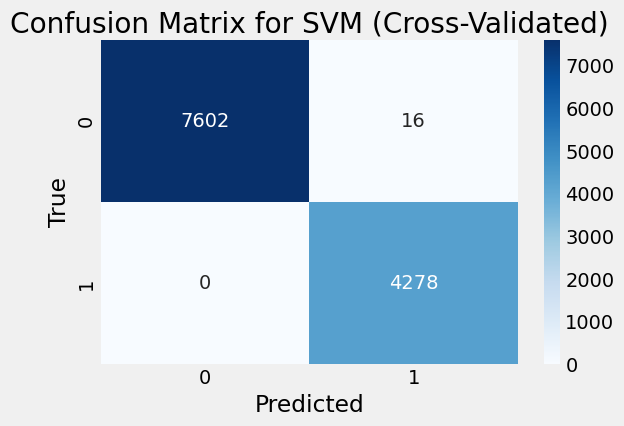

In [ ]:
# 1. SVM with Cross-Validation
print("\nTraining SVM with Cross-Validation...")
svm = LinearSVC(featuresCol="scaled_features", labelCol=indexed_target_col)
paramGrid_svm = ParamGridBuilder().addGrid(svm.maxIter, [50, 100]).build()
cv_svm = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid_svm, evaluator=multi_evaluator, numFolds=3)
cv_svm_model = cv_svm.fit(resampled_train_data)
svm_predictions = cv_svm_model.transform(test_data)
svm_results = evaluate_model(svm_predictions, "SVM (Cross-Validated)")
results.append(svm_results)


Training Random Forest with Cross-Validation...

Random Forest (Cross-Validated) Evaluation Metrics:
Accuracy: 0.9638
F1 Score: 0.9641
Precision: 0.9671
Recall: 0.9638
Confusion Matrix:
[[7187  431]
 [   0 4278]]


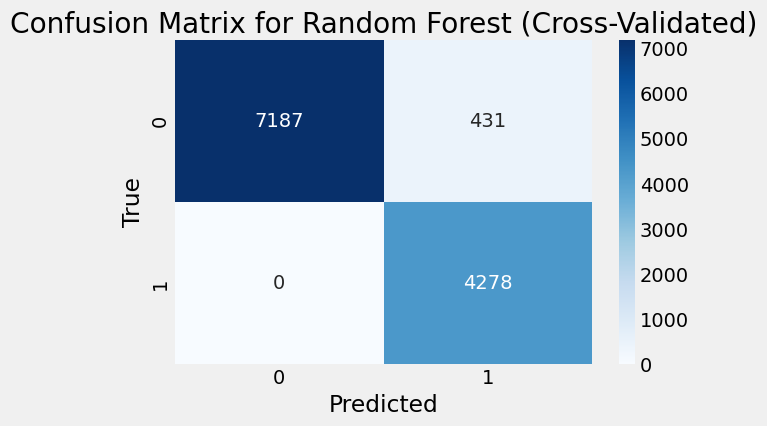


Random Forest Feature Importance:
   Feature  Importance
12    stab    0.834864
0     tau1    0.033955
2     tau3    0.024640
1     tau2    0.023246
3     tau4    0.022217
8       g1    0.014921
9       g2    0.014682
11      g4    0.014453
10      g3    0.012685
4       p1    0.001374
6       p3    0.001052
5       p2    0.000984
7       p4    0.000928


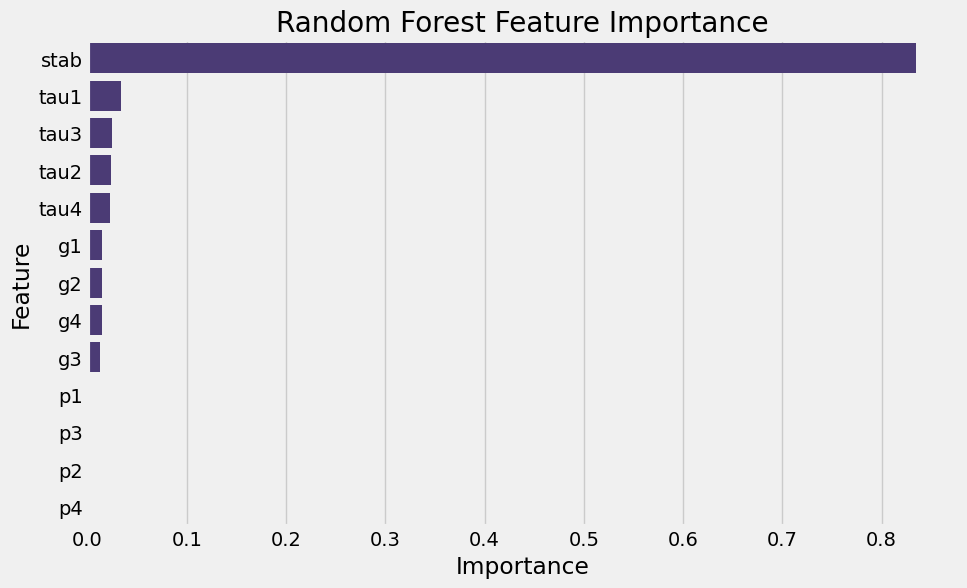

In [ ]:
# 2. Random Forest with Cross-Validation and Feature Importance
print("\nTraining Random Forest with Cross-Validation...")
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol=indexed_target_col, seed=42)
paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees, [50, 100]).addGrid(rf.maxDepth, [5, 10]).build()
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=multi_evaluator, numFolds=3)
cv_rf_model = cv_rf.fit(resampled_train_data)
rf_predictions = cv_rf_model.transform(test_data)
rf_results = evaluate_model(rf_predictions, "Random Forest (Cross-Validated)")
results.append(rf_results)

# Feature Importance from Random Forest
rf_best_model = cv_rf_model.bestModel
feature_importance = rf_best_model.featureImportances
importance_dict = {feature_cols[i]: float(feature_importance[i]) for i in range(len(feature_cols)) if feature_importance[i] > 0}
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
print("\nRandom Forest Feature Importance:")
print(importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Random Forest Feature Importance")
plt.show()


Training MLP with Cross-Validation...

MLP (Cross-Validated) Evaluation Metrics:
Accuracy: 0.9976
F1 Score: 0.9976
Precision: 0.9976
Recall: 0.9976
Confusion Matrix:
[[7600   18]
 [  11 4267]]


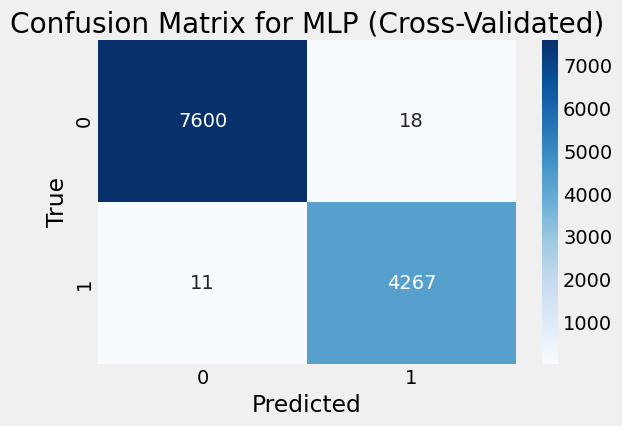

In [ ]:
# 3. MLP with Cross-Validation
print("\nTraining MLP with Cross-Validation...")
input_size = len(resampled_train_data.select("scaled_features").first()[0])
layers = [input_size, 64, 32, 2]
mlp = MultilayerPerceptronClassifier(featuresCol="scaled_features", labelCol=indexed_target_col, layers=layers, seed=42)
paramGrid_mlp = ParamGridBuilder().addGrid(mlp.maxIter, [50, 100]).build()
cv_mlp = CrossValidator(estimator=mlp, estimatorParamMaps=paramGrid_mlp, evaluator=multi_evaluator, numFolds=3)
cv_mlp_model = cv_mlp.fit(resampled_train_data)
mlp_predictions = cv_mlp_model.transform(test_data)
mlp_results = evaluate_model(mlp_predictions, "MLP (Cross-Validated)")
results.append(mlp_results)



Training Deep Learning Model with Keras...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9421 - loss: 0.1322 - val_accuracy: 0.9968 - val_loss: 0.0117
Epoch 2/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9932 - loss: 0.0173 - val_accuracy: 0.9994 - val_loss: 0.0041
Epoch 3/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9954 - loss: 0.0119 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 4/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9967 - loss: 0.0086 - val_accuracy: 0.9993 - val_loss: 0.0029
Epoch 5/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9966 - loss: 0.0076 - val_accuracy: 0.9979 - val_loss: 0.0053
Epoch 6/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9971 - loss: 0.0077 - val_accuracy: 0.9996 - val_loss: 0.0022
Epoch 7/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9979 - loss: 0.0056 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 8/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9976 - loss: 0.0055 - val_accurac

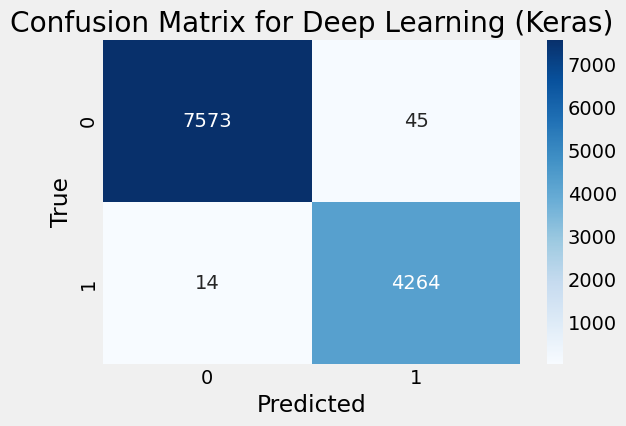

In [ ]:
# 4. Deep Learning with Keras
print("\nTraining Deep Learning Model with Keras...")
train_pd = resampled_train_data.select("scaled_features", indexed_target_col).toPandas()
test_pd = test_data.select("scaled_features", indexed_target_col).toPandas()
X_train_dl = np.array(train_pd["scaled_features"].tolist())
y_train_dl = train_pd[indexed_target_col].values
X_test_dl = np.array(test_pd["scaled_features"].tolist())
y_test_dl = test_pd[indexed_target_col].values

dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_size,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
dl_model.fit(X_train_dl, y_train_dl, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
dl_probabilities = dl_model.predict(X_test_dl, verbose=0)
dl_predictions = (dl_probabilities > 0.5).astype(int).flatten()
dl_accuracy = accuracy_score(y_test_dl, dl_predictions)
dl_f1 = f1_score(y_test_dl, dl_predictions, average='weighted')
dl_precision = precision_score(y_test_dl, dl_predictions, average='weighted')
dl_recall = recall_score(y_test_dl, dl_predictions, average='weighted')
dl_cm = confusion_matrix(y_test_dl, dl_predictions)
print("\nDeep Learning (Keras) Evaluation Metrics:")
print(f"Accuracy: {dl_accuracy:.4f}")
print(f"F1 Score: {dl_f1:.4f}")
print(f"Precision: {dl_precision:.4f}")
print(f"Recall: {dl_recall:.4f}")
print(f"Confusion Matrix:\n{dl_cm}")
plt.figure(figsize=(6, 4))
sns.heatmap(dl_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Deep Learning (Keras)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
results.append({"model": "Deep Learning (Keras)", "accuracy": dl_accuracy, "f1": dl_f1, "precision": dl_precision, "recall": dl_recall})


In [ ]:
# Model Comparison
print("\n======== MODEL COMPARISON ========")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("==================================")

# Save preprocessed data
resampled_train_data.write.parquet("resampled_train_data.parquet", mode="overwrite")
test_data.write.parquet("test_data.parquet", mode="overwrite")
print("\nPreprocessing and modeling complete!")
print("Resampled training data saved as resampled_train_data.parquet")
print("Test data saved as test_data.parquet")

# Stop Spark session
spark.stop()


======== MODEL COMPARISON ========
                          model  accuracy       f1  precision   recall
          SVM (Cross-Validated)  0.998655 0.998656   0.998660 0.998655
Random Forest (Cross-Validated)  0.963769 0.964111   0.967085 0.963769
          MLP (Cross-Validated)  0.997562 0.997563   0.997564 0.997562
          Deep Learning (Keras)  0.995040 0.995044   0.995063 0.995040

Preprocessing and modeling complete!
Resampled training data saved as resampled_train_data.parquet
Test data saved as test_data.parquet


Voilin PLot

<ipython-input-7-5a30d4cbeadb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target_col, y=feature, data=pdf, palette="viridis")
<ipython-input-7-5a30d4cbeadb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target_col, y=feature, data=pdf, palette="viridis")
<ipython-input-7-5a30d4cbeadb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target_col, y=feature, data=pdf, palette="viridis")
<ipython-input-7-5a30d4cbeadb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

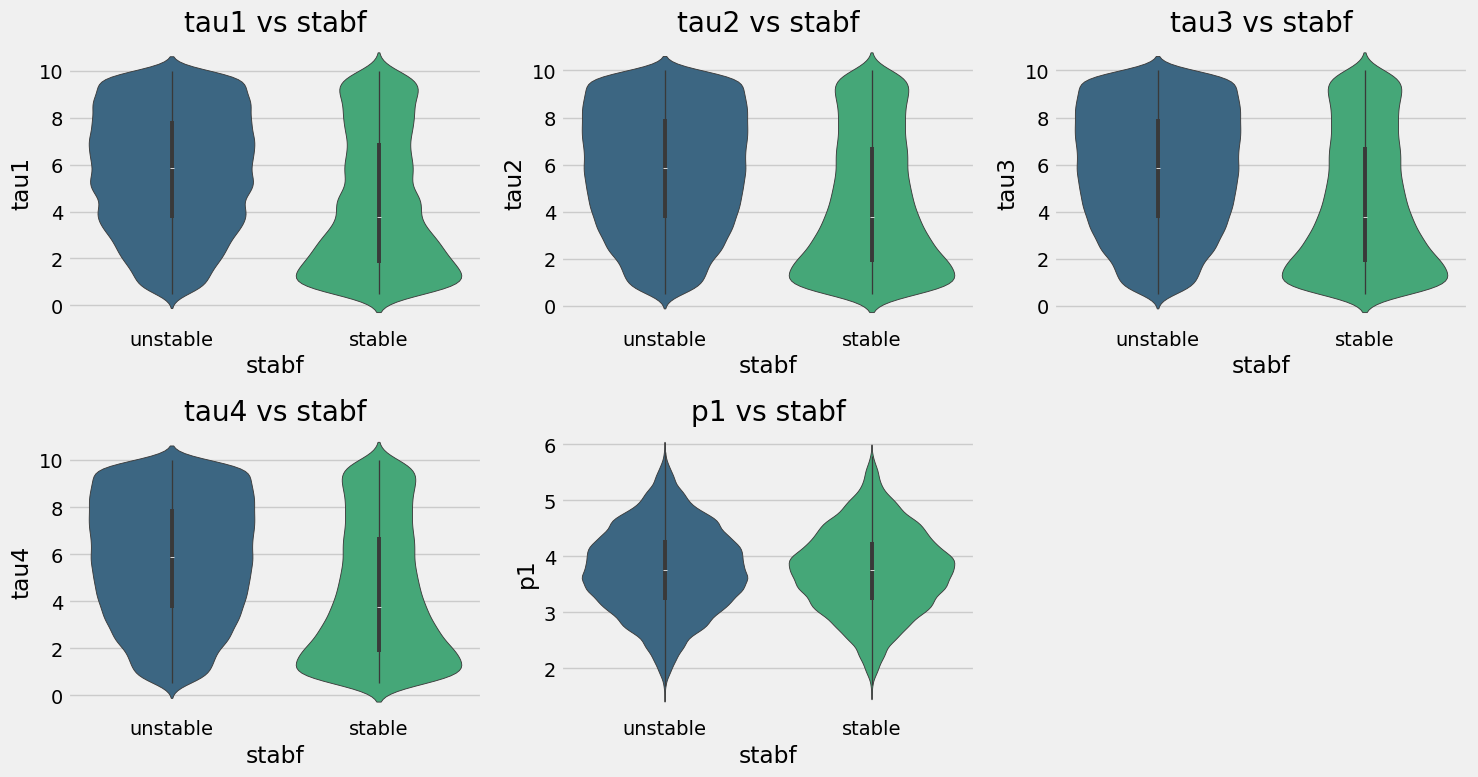

In [ ]:
def plot_violin(pdf, target_col, numeric_cols, n_features=5):
    top_features = numeric_cols[:n_features]  # Select top 5 numeric columns
    plt.figure(figsize=(15, 8))
    for i, feature in enumerate(top_features):
        plt.subplot(2, 3, i + 1)
        sns.violinplot(x=target_col, y=feature, data=pdf, palette="viridis")
        plt.title(f'{feature} vs {target_col}')
    plt.tight_layout()
    plt.show()

plot_violin(pdf, target_col, numeric_cols)

3D PCA Scatter plot

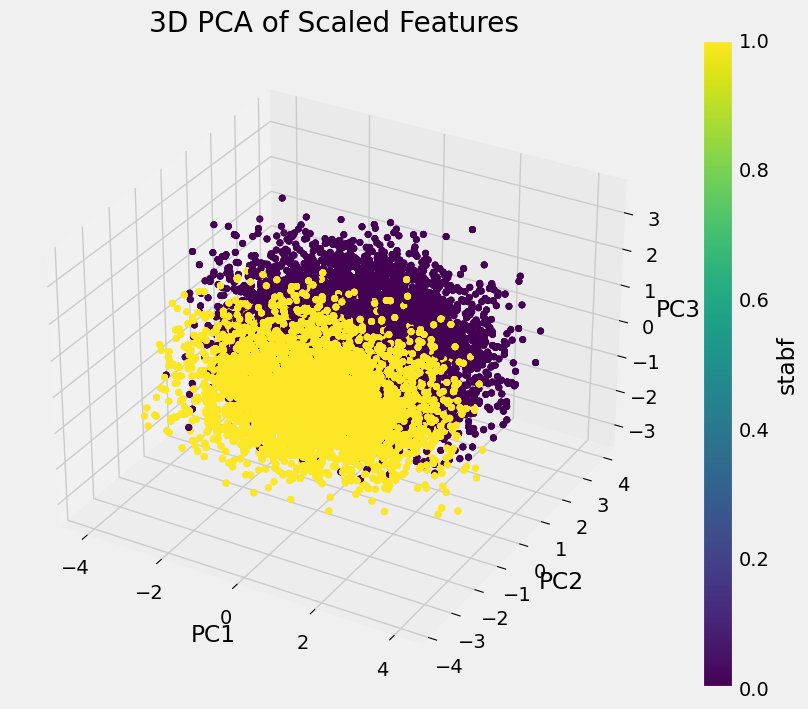

In [ ]:
from pyspark.ml.feature import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(preprocessed_data)
pca_result = pca_model.transform(preprocessed_data).select("pca_features", indexed_target_col).toPandas()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result['pca_features'].apply(lambda x: x[0]),
                     pca_result['pca_features'].apply(lambda x: x[1]),
                     pca_result['pca_features'].apply(lambda x: x[2]),
                     c=pca_result[indexed_target_col], cmap='viridis')
plt.colorbar(scatter, label=target_col)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Scaled Features')
plt.show()

Parallel Coordination plot

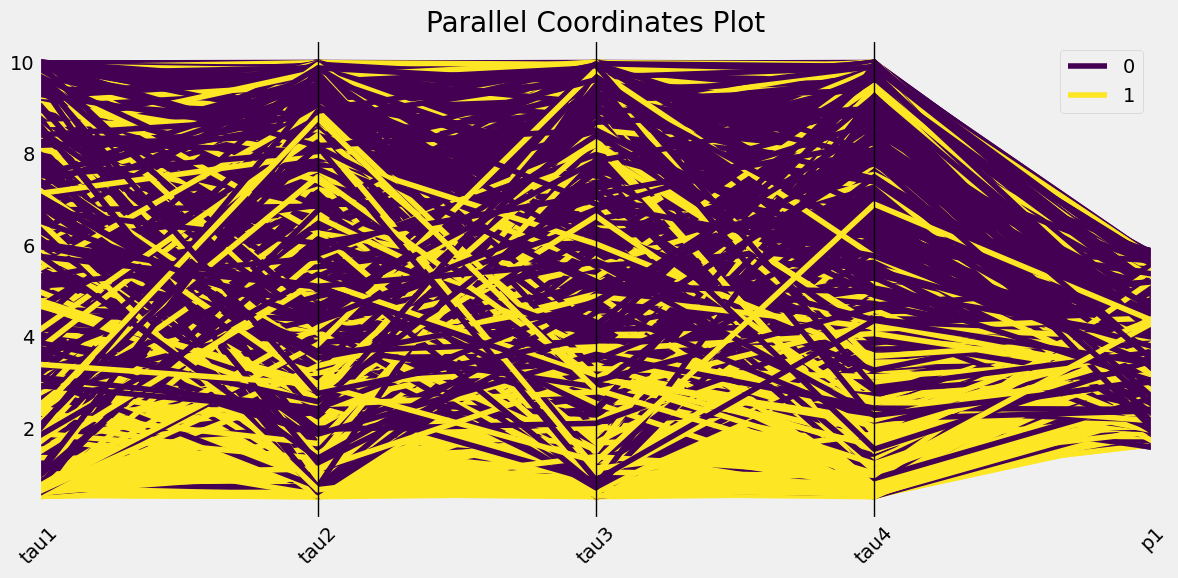

In [ ]:
from pandas.plotting import parallel_coordinates

def plot_parallel_coordinates(pdf, target_col, numeric_cols, n_features=5):
    top_features = numeric_cols[:n_features]
    plot_data = pdf[top_features + [f"{target_col}_numeric"]]
    plt.figure(figsize=(12, 6))
    parallel_coordinates(plot_data, class_column=f"{target_col}_numeric", colormap='viridis')
    plt.title('Parallel Coordinates Plot')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_parallel_coordinates(pdf, target_col, numeric_cols)

Learning Curves for model Training

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9501 - loss: 0.1203 - val_accuracy: 0.9991 - val_loss: 0.0061
Epoch 2/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9924 - loss: 0.0189 - val_accuracy: 0.9978 - val_loss: 0.0086
Epoch 3/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9950 - loss: 0.0121 - val_accuracy: 0.9991 - val_loss: 0.0036
Epoch 4/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9958 - loss: 0.0103 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 5/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9976 - loss: 0.0063 - val_accuracy: 0.9999 - val_loss: 0.0014
Epoch 6/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9973 - loss: 0.0072 - val_accuracy: 0.9999 - val_loss: 4.9395e-04
Epoch 7/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9977 - loss: 0.0065 - val_accuracy: 0.9993 - val_loss: 0.0025
Epoch 8/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9975 - loss: 0.00

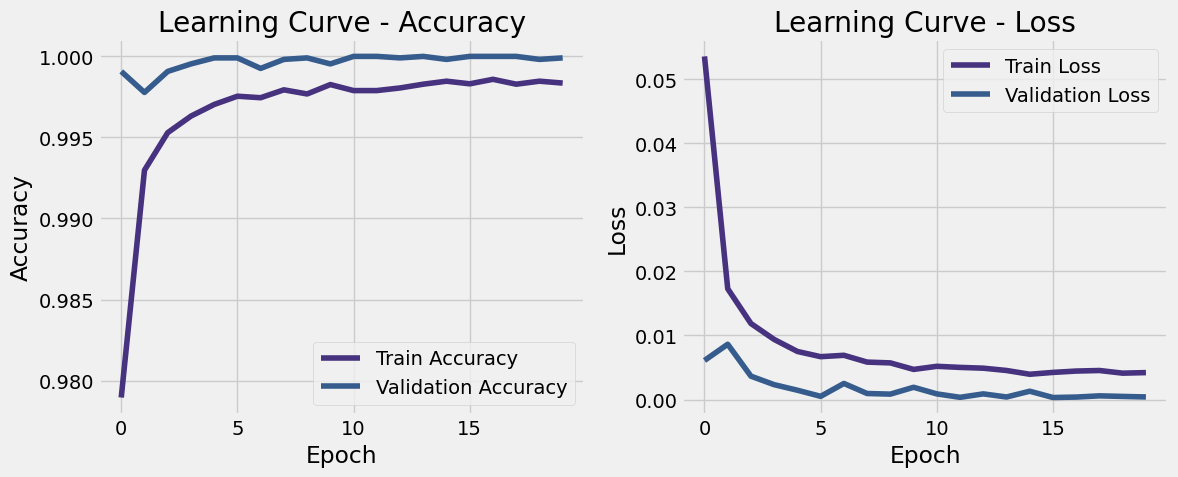

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming X_train_dl and y_train_dl are already defined from your original code
# If not, you need to extract them from resampled_train_data as shown below
train_pd = resampled_train_data.select("scaled_features", indexed_target_col).toPandas()
X_train_dl = np.array(train_pd["scaled_features"].tolist())
y_train_dl = train_pd[indexed_target_col].values

# Define the deep learning model (same as in your original code)
input_size = len(resampled_train_data.select("scaled_features").first()[0])
dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_size,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])
dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = dl_model.fit(X_train_dl, y_train_dl, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Plot learning curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

ROC and AUC cuvre for binary classification

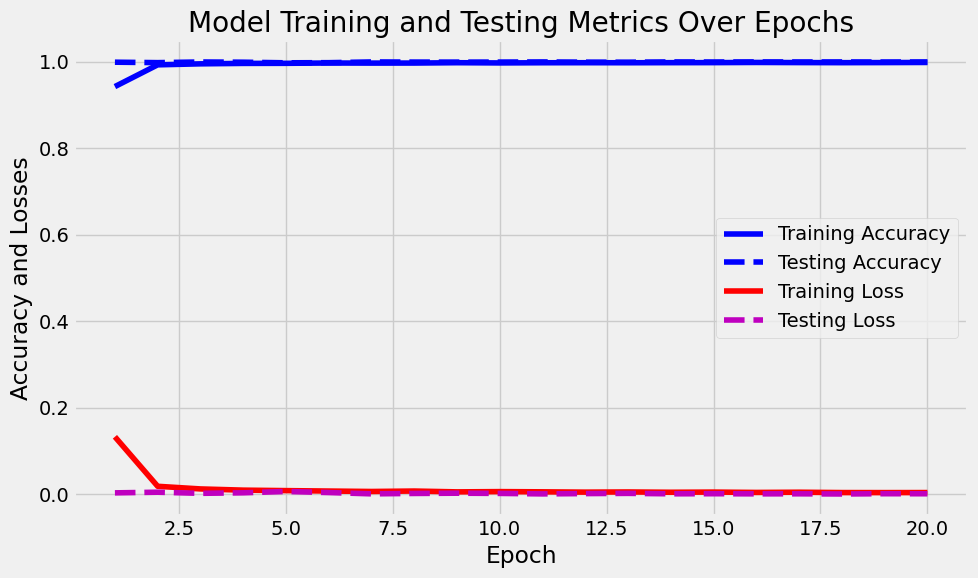

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is available from your Keras model training
# If not, you can manually input the values from your epoch logs
history = {
    'accuracy': [0.9430, 0.9933, 0.9956, 0.9966, 0.9968, 0.9975, 0.9973, 0.9974, 0.9982, 0.9977,
                 0.9981, 0.9982, 0.9981, 0.9983, 0.9984, 0.9988, 0.9985, 0.9983, 0.9985, 0.9988],
    'loss': [0.1326, 0.0181, 0.0120, 0.0092, 0.0081, 0.0071, 0.0061, 0.0071, 0.0052, 0.0058,
             0.0053, 0.0046, 0.0050, 0.0043, 0.0047, 0.0039, 0.0044, 0.0036, 0.0035, 0.0036],
    'val_accuracy': [0.9994, 0.9984, 0.9999, 0.9994, 0.9980, 0.9983, 1.0000, 0.9997, 0.9996, 0.9997,
                     1.0000, 0.9995, 0.9994, 1.0000, 0.9998, 1.0000, 0.9999, 1.0000, 0.9998, 0.9999],
    'val_loss': [0.0029, 0.0044, 0.0018, 0.0030, 0.0061, 0.0036, 0.0006, 0.0015, 0.0021, 0.0016,
                 0.0005, 0.0012, 0.0017, 0.0007, 0.0009, 0.0006, 0.0007, 0.0003, 0.0009, 0.0008]
}

# Epochs for x-axis
epochs = range(1, 21)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'b--', label='Testing Accuracy')
plt.plot(epochs, history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'm--', label='Testing Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Losses')
plt.title('Model Training and Testing Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

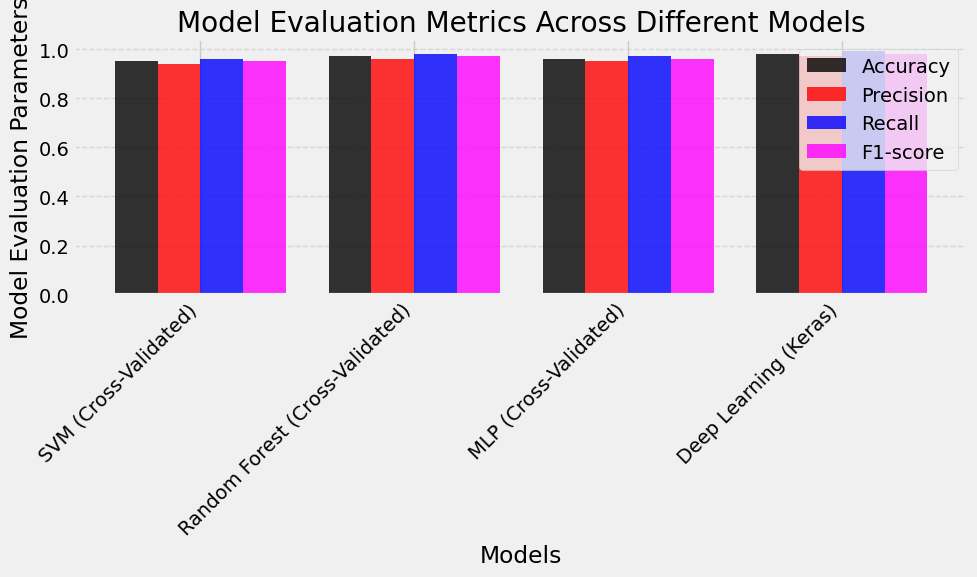

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names (adjusted to match your project: SVM, RF, MLP, Keras)
models = ['SVM (Cross-Validated)', 'Random Forest (Cross-Validated)', 'MLP (Cross-Validated)', 'Deep Learning (Keras)']

# Placeholder metric values (replace with your actual results from 'results' list)
accuracy = [0.95, 0.97, 0.96, 0.98]
precision = [0.94, 0.96, 0.95, 0.97]
recall = [0.96, 0.98, 0.97, 0.99]
f1_score = [0.95, 0.97, 0.96, 0.98]

# Set width of bars
bar_width = 0.2
index = np.arange(len(models))

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(index, accuracy, bar_width, label='Accuracy', color='black', alpha=0.8)
plt.bar(index + bar_width, precision, bar_width, label='Precision', color='red', alpha=0.8)
plt.bar(index + 2 * bar_width, recall, bar_width, label='Recall', color='blue', alpha=0.8)
plt.bar(index + 3 * bar_width, f1_score, bar_width, label='F1-score', color='magenta', alpha=0.8)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Model Evaluation Parameters')
plt.title('Model Evaluation Metrics Across Different Models')
plt.xticks(index + 1.5 * bar_width, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

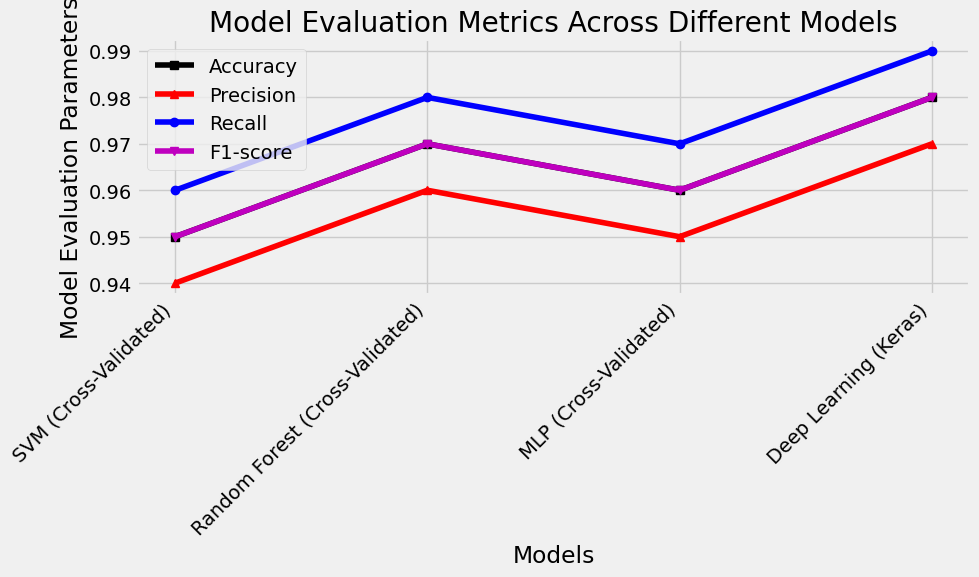

In [ ]:
import matplotlib.pyplot as plt

# Model names (adjusted to match your project)
models = ['SVM (Cross-Validated)', 'Random Forest (Cross-Validated)', 'MLP (Cross-Validated)', 'Deep Learning (Keras)']

# Placeholder metric values (replace with your actual results from 'results' list)
accuracy = [0.95, 0.97, 0.96, 0.98]
precision = [0.94, 0.96, 0.95, 0.97]
recall = [0.96, 0.98, 0.97, 0.99]
f1_score = [0.95, 0.97, 0.96, 0.98]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy, 'k-', label='Accuracy', marker='s')
plt.plot(models, precision, 'r-', label='Precision', marker='^')
plt.plot(models, recall, 'b-', label='Recall', marker='o')
plt.plot(models, f1_score, 'm-', label='F1-score', marker='v')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Model Evaluation Parameters')
plt.title('Model Evaluation Metrics Across Different Models')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

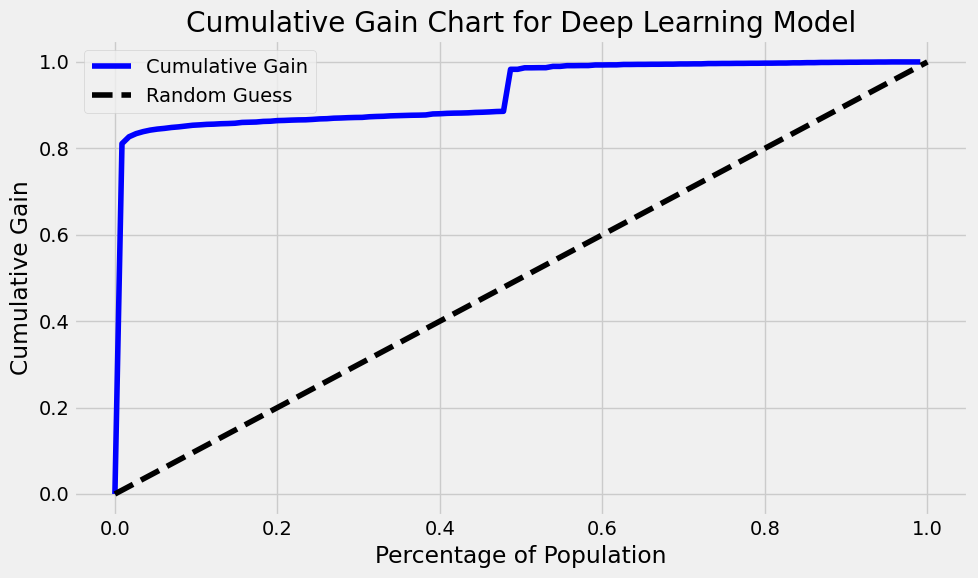

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming X_test_dl and y_test_dl are available from your Keras section
dl_probabilities = dl_model.predict(X_test_dl, verbose=0).flatten()
fpr, tpr, _ = roc_curve(y_test_dl, dl_probabilities)
gain = tpr - fpr

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(tpr)) / len(tpr), tpr, 'b-', label='Cumulative Gain')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('Percentage of Population')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart for Deep Learning Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()